In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [32]:
train = pd.read_csv('train.csv')

## Data Preparation 

In [33]:
from datetime import datetime as dt
train.deadline =pd.to_datetime(train['deadline'],unit='s')#.dt.strftime('%Y%m%d')
train.state_changed_at =pd.to_datetime(train['state_changed_at'],unit='s')#.dt.strftime('%Y%m%d')
train.created_at =pd.to_datetime(train['created_at'],unit='s')#.dt.strftime('%Y%m%d')
train.launched_at =pd.to_datetime(train['launched_at'],unit='s')#.dt.strftime('%Y%m%d')

In [34]:
train['Start2Finsih']= train.deadline - train.created_at
train['Launch2Finsih']= train.deadline - train.launched_at
train['Launch2Status']= train.state_changed_at - train.launched_at
train['Create2Launch']= train.launched_at -train.created_at
#train['Finish2Status']= train.state_changed_at -train.deadline

In [35]:
train['Start2Finsih'] = train['Start2Finsih'].dt.days
train['Launch2Finsih']= train['Launch2Finsih'].dt.days
train['Launch2Status']= train['Launch2Status'].dt.days
train['Create2Launch']= train['Create2Launch'].dt.days
#train['Finish2Status']= train['Finish2Status'].dt.days

In [36]:
train.deadline =pd.to_datetime(train['deadline'],unit='s').dt.strftime('%Y%m%d')
train.state_changed_at =pd.to_datetime(train['state_changed_at'],unit='s').dt.strftime('%Y%m%d')
train.created_at =pd.to_datetime(train['created_at'],unit='s').dt.strftime('%Y%m%d')
train.launched_at =pd.to_datetime(train['launched_at'],unit='s').dt.strftime('%Y%m%d')


In [37]:
train = train.drop(['name','desc','keywords'],axis=1)

In [38]:
train['disable_communication']= train['disable_communication'].astype('str')
train['disable_communication'] = train['disable_communication'].replace(to_replace=['False', 'True'], value=[0, 1])

In [39]:
cur = pd.get_dummies(train.country,prefix='C')
dur = pd.get_dummies(train.disable_communication,prefix='D')

In [40]:
new_train = pd.concat([train,cur],axis=1)

In [41]:
new_train = new_train.drop(['currency','country','project_id','disable_communication'],axis=1)

# Train/Test Split

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
X = new_train.drop('final_status',axis=1)
y = new_train['final_status']

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((81096, 21), (27033, 21), (81096,), (27033,))

# Model

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [46]:
#Accuary libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Hypertunning 
from sklearn.model_selection import GridSearchCV


In [47]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
%%time
log_pred = logreg.predict(X_test)
leg_score = accuracy_score(log_pred,y_test)
print('model 1 accuracy score {}'.format(leg_score))

model 1 accuracy score 0.6793548625753708
Wall time: 81.8 ms


             precision    recall  f1-score   support

          0       0.68      1.00      0.81     18365
          1       0.00      0.00      0.00      8668

avg / total       0.46      0.68      0.55     27033



C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


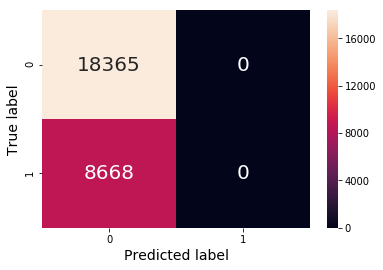

In [49]:
## Use Confusion Matrix to see How model behaviour on Sucess and failure. 
confusion_matrix = confusion_matrix(y_test, log_pred)
confusion_matrix_df = pd.DataFrame(confusion_matrix)
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
print(classification_report(y_test,log_pred))

In [50]:
Knn = KNeighborsClassifier()
Knn.fit(X_train,y_train)
knn_pred = Knn.predict(X_test)
knn_score = accuracy_score(knn_pred, y_test)

print('model 2 accuracy score {}'.format(knn_score))

model 2 accuracy score 0.7804165279473236


In [51]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)
rfc_score = accuracy_score(rfc_pred,y_test)
print('model 3 accuracy score {}'.format(rfc_score))

model 3 accuracy score 0.8526245699700367


In [53]:
print('model 3 Train Accuracy:',accuracy_score(y_train, rfc.predict(X_train)))
print('model 3 Test Accuracy:', accuracy_score(y_test, rfc_pred))

model 3 Train Accuracy: 0.9926136924139292
model 3 Test Accuracy: 0.8526245699700367


So the model 3 is best model on the data so far,but we clearly see an underfitting going on.

# Hyperparameter Tuning 

In [54]:
rfc=RandomForestClassifier(random_state=42)
from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc,param_grid =param_grid,cv= 5,verbose =1,n_jobs = -1)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 24.1min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [55]:
print('rfc best params:', CV_rfc.best_params_)
print('rfc scores:', CV_rfc.best_score_)

rfc best params: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}
rfc scores: 0.8614358291407714


In [56]:
CV_ref_pred = CV_rfc.predict(X_test)

In [57]:
print('Train Accuracy:',accuracy_score(y_train, CV_rfc.predict(X_train)))
print('Test Accuracy:', accuracy_score(y_test, CV_ref_pred))

Train Accuracy: 0.8688221367268423
Test Accuracy: 0.8572485480708764


# Save Model 

In [24]:
import pickle

In [25]:
with open('KickStart_model.pkl', 'wb') as f:
    pickle.dump(rfc1, f)

In [26]:
with open('KickStart_model.pkl', 'rb') as f:
    rfc1_loaded = pickle.load(f)

# Test Flask in Production


In [85]:
 
import requests
import json
from data_input import data_in


In [86]:
url = 'http://127.0.0.1:5000/predict'


In [96]:
data = json.dumps(data_in)
print('inputs : {}'.format(data))
r_survey = requests.get(url, data)
print('url link for response: {}'.format(url))
print('API response : {}'.format(r_survey))
print('output the prediction : {}'.format(r_survey.json()))

inputs : [1000, "20120601", "20120601", "20120419", "20120502", 19, 42, 30, 30, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
url link for response: http://127.0.0.1:5000/predict
API response : <Response [200]>
output the prediction : {'response': 0.0}


# Test App in Heroku 

In [119]:
heroku_url = 'https://kickstarter001.herokuapp.com/'
import json
data = {'goal':1000,
'deadline':'20120601',
'state_changed_at':'20120601',
'created_at':'20120419',
'launched_at':'20120502',
'backers_count':19,
'Start2Finsih':42,
'Launch2Finsih':30,
'Launch2Status':30,
'Create2Launch':12,
'C_AU':0,
'C_CA':0,
'C_DE':0,
'C_DK':0,
'C_GB':0,
'C_IE':0,
'C_NL':0,
'C_NO':0,
'C_NZ':0,
'C_SE':0,
'C_US':1}

data = json.dumps(data)

In [120]:
send_request = requests.get(url, data)
print(send_request)

<Response [200]>


In [121]:
print(send_request.json())


{'response': 0.0}
